# bibliotecas usadas para manipulação do projeto


In [15]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

# Define a transformação para converter as imagens em tensores PyTorch

## carregando imagens do MNIST e exibindo um exemplo de imagem para teste

In [43]:

transform = transforms.ToTensor()

# Carrega o conjunto de dados de treinamento do MNIST
# Se os dados não estiverem presentes no caminho especificado, eles serão baixados.
# train=True especifica que queremos o conjunto de treinamento.
# transform=transform aplica a transformação definida acima aos dados.
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)
# Cria um DataLoader para o conjunto de treinamento.
# Um DataLoader ajuda a carregar os dados em lotes (batches) para o treinamento.
# batch_size=64 define o número de amostras por lote.
# shuffle=True embaralha os dados a cada época para melhorar o treinamento.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Carrega o conjunto de dados de validação do MNIST
# train=False especifica que queremos o conjunto de validação.
valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)
# Cria um DataLoader para o conjunto de validação com as mesmas configurações.
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

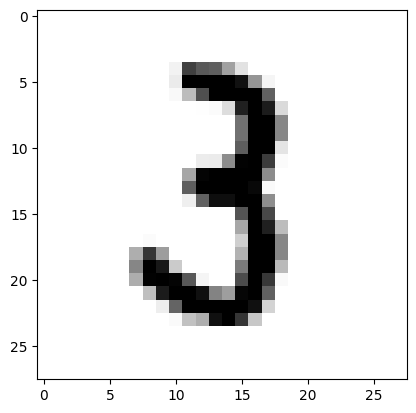

In [45]:
dataiter = iter(trainloader)
imagens, etiquetas = dataiter.__next__()

plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

## imprimindo dimensões e etiquetas da imagm teste

In [46]:
print(imagens[0].shape)  # dimensões do tensor de cada imagem
print(etiquetas[0].shape)  # dimensões da etiqueta de cada imagem

torch.Size([1, 28, 28])
torch.Size([])


# Definindo a estrutura do modelo usado na rede neural.

[Keras InceptionV3](https://keras.io/api/applications/inceptionv3/)

In [47]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neurônios que se ligam a 10
        # para a camada de saída não e necessário definir nada pois só precisamos pegar o output da camada interna 2

    def forward(self, X):
        X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X) # função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda

# Definindo os parametros usados no modelo de treinamento

In [52]:
def treino(modelo, trainloader, device):

    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a polítca de atualização dos peso
    inicio = time() # timer para sabermos quanto tempo levou o treino

    criterio = nn.NLLLoss() # definindo o criterio para calcular a perda
    EPOCHS = 10 # numero de epochs que o algoritmo rodará
    modelo.train() # ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão

        for imagens, etiquetas in trainloader:

            imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para "vetores" de 28*28 casas
            otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device)) # colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão

            perda_instantanea.backward() # back propagation a partir da perda

            otimizador.step() # atualizando os pesos e a bias

            perda_acumulada += perda_instantanea.item() # atualização da perda

        else:
          print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
    print("\nTempo de treino (em minutos) =", (time()-inicio)/60)

# Validando os resultados obtidos pelo modelo

In [53]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)
            # desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
            with torch.no_grad():
                logps = modelo(img.to(device)) # output do modelo em escala logaritmica

            ps = torch.exp(logps) # converte output para escala normal(lembrando que é um tensor)
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab)) # converte o tensor em um número, no caso, o número que o modelo
            etiqueta_certa = etiquetas.numpy()[i]
            if(etiqueta_certa == etiqueta_pred): # compara a previsão com o valor correto
                conta_corretas += 1
            conta_todas += 1

    print("\nTotal de imagens testadas =", conta_todas)
    print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

## Definindo se o modelo vai usar o cuda "GPU da Nvidia" ou o CPU para processamento.

### Nesse caso o Colab fornece o ambiente Cuda

In [54]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

# Exibindo os resultados dos treinamentos por tempos e suas perdas por cada iteração

In [55]:
treino(modelo, trainloader, device)
validacao(modelo, valloader, device)

Epoch 1 - Perda resultante: 1.1442762069515329
Epoch 2 - Perda resultante: 0.3728266578398025
Epoch 3 - Perda resultante: 0.3077103443729725
Epoch 4 - Perda resultante: 0.27101501874895745
Epoch 5 - Perda resultante: 0.24245150557268402
Epoch 6 - Perda resultante: 0.21697487278597188
Epoch 7 - Perda resultante: 0.19530885265881953
Epoch 8 - Perda resultante: 0.1775705257752366
Epoch 9 - Perda resultante: 0.16187792239603457
Epoch 10 - Perda resultante: 0.148307273243822

Tempo de treino (em minutos) = 1.9668451150258381

Total de imagens testadas = 10000

Precisão do modelo = 95.7%


# Exibindo os resultados de forma visual
# Task

Visualize algumas previsões do modelo no conjunto de validação, exibindo a imagem, o rótulo previsto e o rótulo verdadeiro para alguns exemplos.

## Obter um lote de dados

### Subtask:
Obtenha um lote de imagens e rótulos do carregador de dados de validação.

In [57]:
dataiter_val = iter(valloader)
imagens_val, etiquetas_val = dataiter_val.__next__()

## Fazer previsões

### Subtask:
Passe as imagens pelo modelo treinado para obter as previsões do modelo.


In [58]:
imagens_val = imagens_val.view(imagens_val.shape[0], -1)
imagens_val = imagens_val.to(device)
with torch.no_grad():
    logps_val = modelo(imagens_val)

## Processar previsões

### Subtask:
Converta a saída do modelo (probabilidades logarítmicas) em rótulos de classe previstos reais.

In [59]:
ps_val = torch.exp(logps_val)
_, etiquetas_pred_val = torch.max(ps_val, dim=1)

## Visualizar resultados

### Subtask:
Exiba algumas imagens do lote, mostrando a imagem em si, o rótulo previsto pelo modelo e o rótulo verdadeiro.

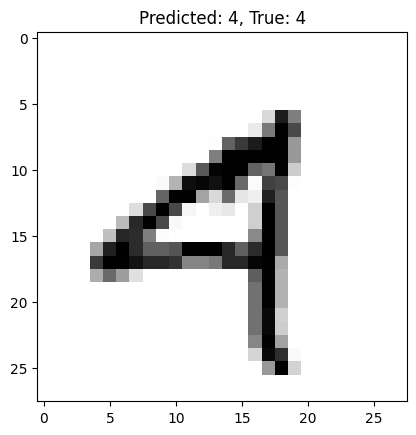

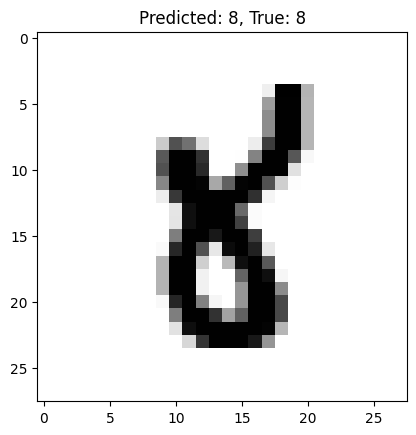

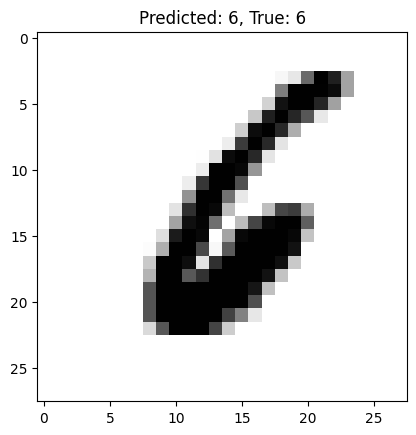

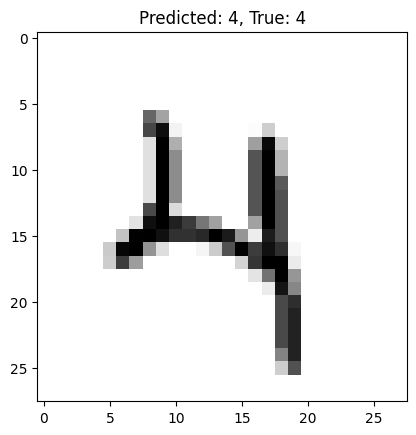

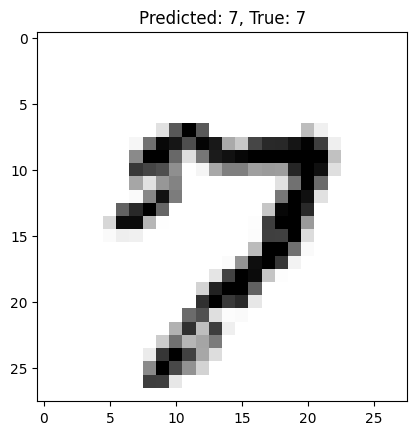

In [62]:
# Display a few predictions from the validation set
num_images_to_display = 5

for i in range(min(num_images_to_display, len(etiquetas_val))):
    img = imagens_val[i].view(1, 28, 28)
    img = img.squeeze()
    plt.imshow(img.cpu().numpy(), cmap='gray_r')
    plt.title(f"Predicted: {etiquetas_pred_val[i].item()}, True: {etiquetas_val[i].item()}")
    plt.show()

## Resumo:

### Principais Descobertas da Análise de Dados

* Um lote de imagens e rótulos foi obtido com sucesso do carregador de dados de validação.
* As imagens de validação foram processadas pelo modelo, resultando em probabilidades logarítmicas das classes previstas.
* As probabilidades logarítmicas foram convertidas em rótulos de classe previstos.
* As primeiras cinco imagens do lote foram visualizadas, cada uma exibindo a imagem, o rótulo previsto pelo modelo e o rótulo verdadeiro.

### Insights ou Próximos Passos

* A inspeção visual dos gráficos permite uma avaliação qualitativa do desempenho do modelo em exemplos individuais.
* Análises adicionais podem envolver a visualização de mais exemplos, incluindo aqueles em que o modelo fez previsões incorretas, para entender possíveis modos de falha.

In [63]:
print(f"O modelo usou {len(trainset)} imagens para treinamento.")

O modelo usou 60000 imagens para treinamento.


In [64]:
print(f"O modelo usou {len(valset)} imagens para validação/previsão.")

O modelo usou 10000 imagens para validação/previsão.
